<a href="https://colab.research.google.com/github/Sowmyad15/SMS_Spam/blob/main/Supervised_BERT_Downsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
from sklearn.metrics import silhouette_score


In [2]:
df=pd.read_csv('/content/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
df = df.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["label", "message"]
df['label_num']=df['label'].map({
    'ham':0,
    'spam':1
})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:

df_spam = df[df['label']=='spam']

df_ham = df[df['label']=='ham']

print("Ham Dataset Shape:", df_ham.shape)

print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (4825, 3)
Spam Dataset Shape: (747, 3)


In [5]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 3)

In [6]:
df= pd.concat([df_spam , df_ham_downsampled])

In [7]:
df['label_num'].value_counts()

1    747
0    747
Name: label_num, dtype: int64

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)
df['preprocessed_txt'] = df['message'].apply(preprocess)
df.head()

,label,message,label_num,preprocessed_txt
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,FreeMsg hey darle 3 week word like fun tb ok X...
8,spam,WINNER!! As a valued network customer you have...,1,WINNER value network customer select receivea ...
9,spam,Had your mobile 11 months or more? U R entitle...,1,mobile 11 month u r entitle update late colour...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1,"chance win cash 100 20,000 pound txt > CSH11 s..."


In [9]:
from sklearn.model_selection import train_test_split



In [10]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens.to(device))
    embeddings = output.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings


In [13]:
df['bert_embedding'] = df['preprocessed_txt'].apply(get_bert_embedding)


In [14]:
X = np.vstack(df['bert_embedding'].to_numpy())

In [15]:
X

array([[ 0.06960295, -0.02238685,  0.67938733, ..., -0.05759511,
        -0.0646834 ,  0.28856483],
       [ 0.156755  ,  0.07545407,  0.7172379 , ..., -0.24080218,
         0.03223718,  0.19361259],
       [ 0.08151105,  0.03403788,  0.38506815, ..., -0.28555986,
        -0.09771109,  0.2225598 ],
       ...,
       [ 0.13393268, -0.01666133,  0.1037871 , ..., -0.06187162,
         0.1689926 , -0.05245724],
       [-0.1477453 ,  0.12119778,  0.229929  , ...,  0.16631447,
         0.09751819,  0.03545141],
       [ 0.51046365, -0.4734    ,  0.1801233 , ...,  0.03112998,
         0.07408084,  0.26697826]], dtype=float32)

In [16]:
len(X)

1494

In [17]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X)

In [18]:
reduced_embeddings

array([[-2.4152977 , -0.10376818],
       [-1.240979  ,  1.6967685 ],
       [-2.4022217 , -1.3578349 ],
       ...,
       [ 1.6995648 , -0.13029745],
       [ 2.9024286 , -2.5960348 ],
       [ 2.0071797 , -1.3469635 ]], dtype=float32)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    reduced_embeddings,
    df.label_num,
    test_size=0.2,
    random_state=42
)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report


lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)

pred=lr.predict(X_test)

accuracy=accuracy_score(y_test,pred)
report=classification_report(y_test,pred)

print(f'Accuracy: {accuracy}\nClassification Report:\n{report}')

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_test, pred)

print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9565217391304348
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       154
           1       0.95      0.96      0.96       145

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299

Confusion Matrix:
[[147   7]
 [  6 139]]


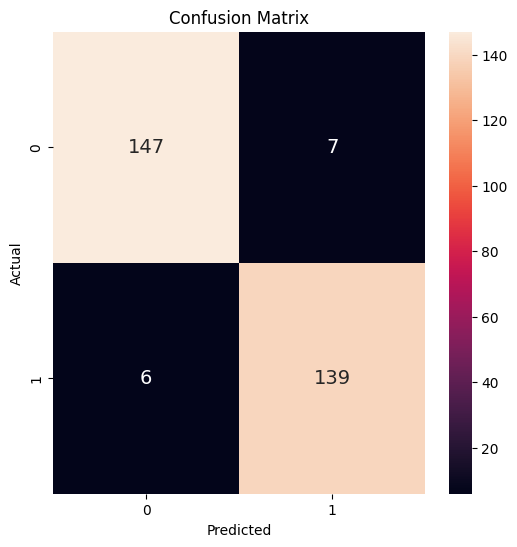

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=True, annot_kws={"size": 14})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()